GitHub: https://github.com/CamWood7/WoodCancer/

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Description of Problem

Convolutional Neural Networks are a class of deep learning models designed to process data with grid-like topology, namely with images. These networks excel in image-related tasks by using convolutional layers to automatically learn and extract spatial features. Each layer applies filters to the input image, and identifies patters. We can introduce pooling layers to reduce dimensions with preserving important features, and everything maps to a final output.

This data set is a binary classification problem involving the identification of metastatic cancer in small image patches from larger pathology scans. The goal is to develop an algorithm that distinguishes between cancerous and non-cancerous tissue. 

# EDA

We'll start by loading in the training data and the validation data, which will be used at submission.

In [2]:
trainPath = '/kaggle/input/histopathologic-cancer-detection/train/'
testPath = '/kaggle/input/histopathologic-cancer-detection/test/'
labels = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')

We can now look at the example of our labels, and see that we have 440,050 examples of data to work with.

In [3]:
print(labels.head())
print(labels.size)

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
440050


We'll look at examples of a handful of the Cancer Positive and Cancer Negative images. The images themselves are 96x96 in size, with 3 color channels.

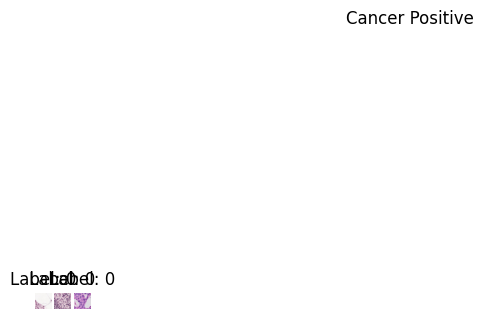

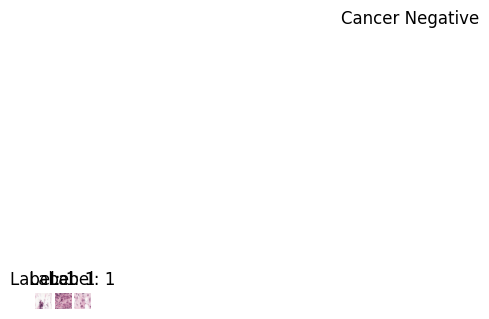

In [4]:
def pltImages(ids, labels, path, title):
    plt.figure(figsize=(10,6))
    for i, (imgId, label) in enumerate(zip(ids, labels)):
        imgPath = os.path.join(path, imgId + '.tif')
        img = Image.open(imgPath)
        plt.subplot(1, len(imgId), i+1)
        plt.imshow(img)
        plt.title(f'Label: {label}')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()
    
pltImages(labels[labels['label'] == 0]['id'][:3], [0]*3, trainPath, 'Cancer Positive')
pltImages(labels[labels['label'] == 1]['id'][:3], [1]*3, trainPath, 'Cancer Negative')

And now we can look at the distribution of Cancer Positive and Cancer Negative Images. They are relatively even, with a slight bias towards Cancer Negative images.

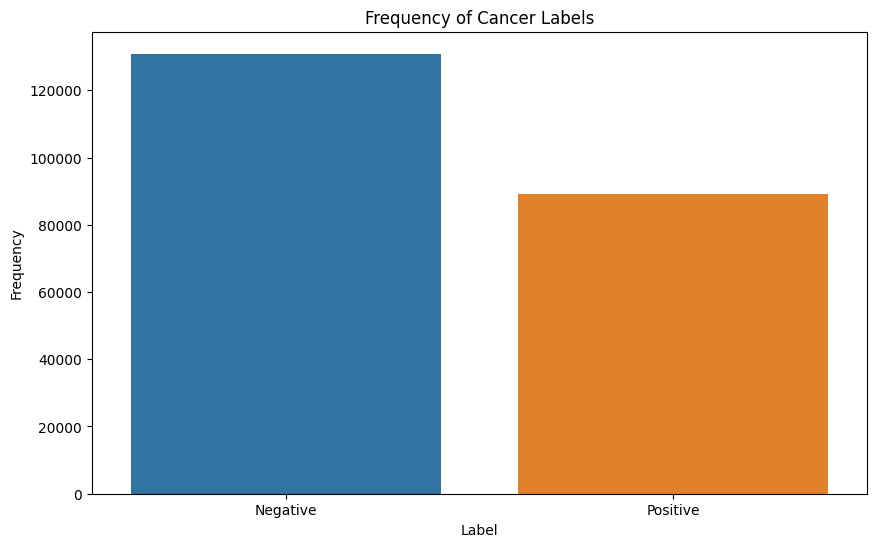

In [5]:
plt.figure(figsize=(10,6))
sns.countplot(x='label', data=labels)
plt.title('Frequency of Cancer Labels')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.xticks(ticks=[0,1],labels=['Negative','Positive'])
plt.show()

Now we can pre-process the data. We'll start by splitting the training data into 20% test and 80% train. We'll then convert the labels into strings instead of ints to agree with the flow_from_dataframe input, and then set up the paths. We finally normalize the images and alter the orientation.

In [6]:
trainLab, valLab = train_test_split(labels, test_size = 0.2, stratify = labels['label'], random_state=11)

trainLab['label'] = trainLab['label'].astype(str)
valLab['label'] = valLab['label'].astype(str)

trainLab['path'] = trainLab['id'] + '.tif'
valLab['path'] = valLab['id'] + '.tif'

trainGen = ImageDataGenerator(rescale = 1./255, horizontal_flip = True, vertical_flip = True)
valGen = ImageDataGenerator(rescale = 1./255)

print("After Generator")
trainData = trainGen.flow_from_dataframe(dataframe = trainLab,
                                        directory = trainPath,
                                        x_col = 'path',
                                        y_col = 'label',
                                        target_size = (96,96),
                                        batch_size = 32,
                                        class_mode = 'binary')

print("After TrainGen")
valData = valGen.flow_from_dataframe(dataframe = valLab,
                                        directory = trainPath,
                                        x_col = 'path',
                                        y_col = 'label',
                                        target_size = (96,96),
                                        batch_size = 32,
                                        class_mode = 'binary')

After Generator
Found 176020 validated image filenames belonging to 2 classes.
After TrainGen
Found 44005 validated image filenames belonging to 2 classes.


# Model Building and Training

We'll start off with a pretty basic CNN model to start, and this will help us do our hyper parameter tuning without waiting too long on training time.

We have the input layer with the shape of the input images (96x96x3), and then followed by two convolutional layers. The first applies 16 filters of size 3x3, and then next has 32 filters of the same size. Each have ReLU padding with batch normalization. We add in a Global Average Pooling layer to reduce the dimensionality of features. Finally we have the fully connected dense layer with 64 units, and a dropout rate of 50% to try and prevent overfitting. The final layer has 2 units with a sigmoid activation function.

In [7]:
def createModel(shape):
    model = Sequential()
    
    model.add(Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    
    model.add(GlobalAveragePooling2D())
    
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(2, activation='sigmoid'))
    
    return model

shape = (96, 96, 3)

model = createModel(shape)

model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

modelBase = model
modelLargeBatch = model
modelLongEpoch = model

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 96, 96, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 96, 96, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 48, 48, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,522 (29.38 KB)

 Trainable params: 7,426 (29.01 KB)

 Non-trainable params: 96 (384.00 B)

We'll first start by changing the batch_size input for fitting to see how that impacts the accuracy and loss.

In [8]:
historyBase = modelBase.fit(trainData,
                            epochs = 1,
                            validation_data = valData)

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5501/5501 ━━━━━━━━━━━━━━━━━━━━ 1503s 273ms/step - accuracy: 0.8077 - loss: 0.4330 - val_accuracy: 0.8009 - val_loss: 0.4402


In [9]:
historyLargeBatch = modelLargeBatch.fit(trainData,
                                        epochs = 1,
                                        batch_size = 64,
                                        validation_data = valData)

5501/5501 ━━━━━━━━━━━━━━━━━━━━ 1214s 220ms/step - accuracy: 0.8583 - loss: 0.3391 - val_accuracy: 0.8776 - val_loss: 0.2968


The increased batch size seems to improve accuracy by about 5%, and lower the loss 10%. We'll move forward with a batch size of 64 images, and move on to increasing our number of epochs.

In [10]:
historyLongEpoch = modelLongEpoch.fit(trainData,
                                      epochs = 5,
                                      batch_size = 64,
                                      validation_data = valData)

Epoch 1/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 1133s 206ms/step - accuracy: 0.8723 - loss: 0.3118 - val_accuracy: 0.7984 - val_loss: 0.4765
Epoch 2/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 1158s 210ms/step - accuracy: 0.8801 - loss: 0.2934 - val_accuracy: 0.8588 - val_loss: 0.3775
Epoch 3/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 1048s 190ms/step - accuracy: 0.8865 - loss: 0.2812 - val_accuracy: 0.8594 - val_loss: 0.3609
Epoch 4/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 1038s 189ms/step - accuracy: 0.8907 - loss: 0.2746 - val_accuracy: 0.7734 - val_loss: 0.4754
Epoch 5/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 1045s 190ms/step - accuracy: 0.8937 - loss: 0.2688 - val_accuracy: 0.8928 - val_loss: 0.2576


Increasing the number of epochs allowed the model to improve training accuracy by 3%, and further reduced the loss.

We'll move onto another model, which adds in another convolutional layer with 64 filters. This will hopefully further refine the feature set and lead to improved training accuracy.

In [11]:
def createBetterModel(shape):
    model = Sequential()
    
    model.add(Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    
    model.add(GlobalAveragePooling2D())
    
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(2, activation='sigmoid'))
    
    return model

shape = (96, 96, 3)

model2 = createBetterModel(shape)

model2.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 96, 96, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 96, 96, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 48, 48, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 48, 48, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,322 (110.63 KB)

 Trainable params: 28,098 (109.76 KB)

 Non-trainable params: 224 (896.00 B)

In [12]:
historyBetter = model2.fit(trainData,
                           epochs = 5,
                           batch_size = 64,
                           validation_data = valData)

Epoch 1/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 1274s 231ms/step - accuracy: 0.8281 - loss: 0.3976 - val_accuracy: 0.8700 - val_loss: 0.3158
Epoch 2/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 1213s 220ms/step - accuracy: 0.8876 - loss: 0.2806 - val_accuracy: 0.8698 - val_loss: 0.3063
Epoch 3/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 1202s 218ms/step - accuracy: 0.9046 - loss: 0.2484 - val_accuracy: 0.8936 - val_loss: 0.2667
Epoch 4/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 1183s 215ms/step - accuracy: 0.9147 - loss: 0.2239 - val_accuracy: 0.7413 - val_loss: 1.7828
Epoch 5/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 1170s 213ms/step - accuracy: 0.9200 - loss: 0.2120 - val_accuracy: 0.8971 - val_loss: 0.2627


Our assumption was right that our training accuracy would improve over the base model, so next we'll take a look at overall performance.

# Results

Let's compare our base model and improved model, both of which had 5 epochs to train and a batch size of 64 images. We'll look at Training Loss and Training Accuracy.

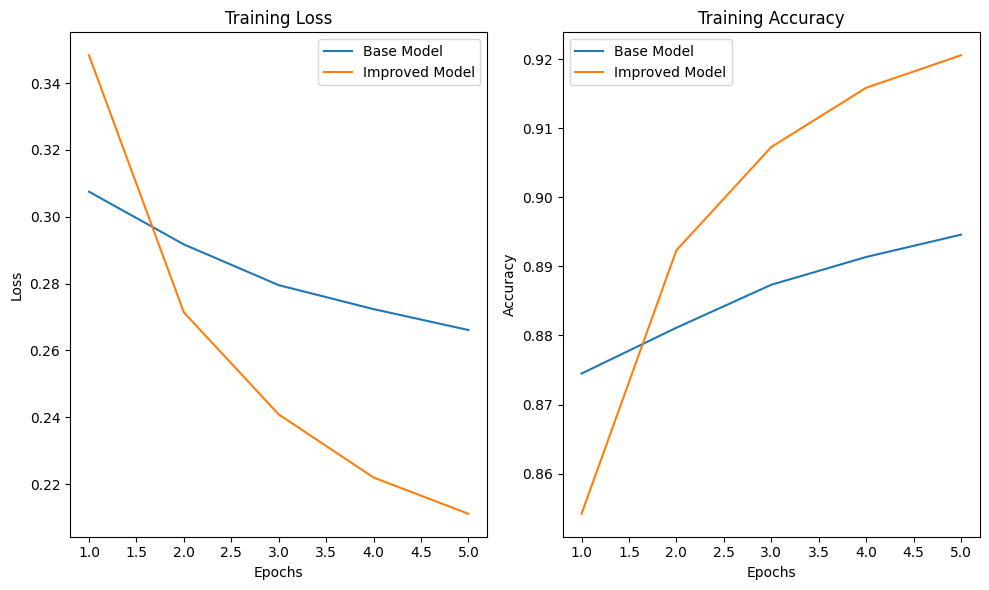

In [13]:
plt.figure(figsize=(10,6))

plt.subplot(1,2,1)
plt.plot(range(1, len(historyLongEpoch.history['loss']) + 1), historyLongEpoch.history['loss'], label='Base Model')
plt.plot(range(1, len(historyBetter.history['loss']) + 1), historyBetter.history['loss'], label='Improved Model')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(1, len(historyLongEpoch.history['accuracy']) + 1), historyLongEpoch.history['accuracy'], label='Base Model')
plt.plot(range(1, len(historyBetter.history['accuracy']) + 1), historyBetter.history['accuracy'], label='Improved Model')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

As we can see, our training loss drops considerably in the improved model, and ends with 6% lower loss than the base model. The accuracy is also notably better, with an increase of 3%. By adding in the extra filters we introduce deeper feature extraction and increased capacity, leading to these improvements.

Now we can look at the classification report to see how our model performs on the validation data.

In [14]:
yPredBase = np.round(modelLongEpoch.predict(valData))
report1 = classification_report(valLab['label'].astype(int), np.argmax(yPredBase, axis=1))
print(report1)

yPredBetter = np.round(model2.predict(valData))
report2 = classification_report(valLab['label'].astype(int), np.argmax(yPredBetter, axis=1))
print(report2)

1376/1376 ━━━━━━━━━━━━━━━━━━━━ 182s 132ms/step
              precision    recall  f1-score   support

           0       0.60      0.58      0.59     26182
           1       0.41      0.43      0.42     17823

    accuracy                           0.51     44005
   macro avg       0.50      0.50      0.50     44005
weighted avg       0.52      0.51      0.52     44005

1376/1376 ━━━━━━━━━━━━━━━━━━━━ 100s 73ms/step
              precision    recall  f1-score   support

           0       0.60      0.67      0.63     26182
           1       0.41      0.34      0.37     17823

    accuracy                           0.53     44005
   macro avg       0.50      0.50      0.50     44005
weighted avg       0.52      0.53      0.52     44005



As you can see, our model performs very poorly on the validation data, only acheiving an accuracy of 53% on the base model and 52% on the improved model. We'll discuss more in the next section on potential short-comings.

# Conclusion and Discussion

As we mentioned, we obtained training accuracies of around 90% on both the base and improved models, but only 50% on each on the validation data. Why is that?
1. The model may be too complex for the amount of training data available. With multiple convolutional layers and dense layers, it could be learning patterns too specific to the training data and failing to generalize. 
2. The dropout rate may not be good enough, and not allowing for proper regularization.
3. We potentially let the model train for too many epochs, and we would have benefitted by using less epochs in the long run.
4. We did not tune the learning rate, which could help in optimizing the model for the validation data.

In the end, we will still submit the "improved" model to place on the leaderboard somewhere.

In [15]:
testFileNames = os.listdir(testPath)
print(f"Total test images: {len(testFileNames)}")

testDf = pd.DataFrame({'path': testFileNames})
testGen = ImageDataGenerator(rescale = 1./255)

testData = testGen.flow_from_dataframe(dataframe = testDf,
                                        directory = testPath,
                                        x_col = 'path',
                                        y_col = None,
                                        target_size = (96,96),
                                        batch_size = 32,
                                        class_mode = None,
                                        shuffle=False)

yTest = np.round(model2.predict(testData, verbose=1))
testDf['id'] = testDf['path'].str.replace('.tif','',regex=False)
testDf['label'] = np.argmax(yTest, axis=1)

submission = testDf[['id', 'label']]
submission['label'] = submission['label'].clip(0,1)

submission.to_csv('submission.csv', index=False)
print(submission.head())

Total test images: 57458
Found 57458 validated image filenames.


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1796/1796 ━━━━━━━━━━━━━━━━━━━━ 353s 197ms/step
                                         id  label
0  a7ea26360815d8492433b14cd8318607bcf99d9e      0
1  59d21133c845dff1ebc7a0c7cf40c145ea9e9664      0
2  5fde41ce8c6048a5c2f38eca12d6528fa312cdbb      0
3  bd953a3b1db1f7041ee95ff482594c4f46c73ed0      0
4  523fc2efd7aba53e597ab0f69cc2cbded7a6ce62      0


/tmp/ipykernel_17/3679794336.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission['label'] = submission['label'].clip(0,1)
